# PDHG Non-cartesian
This notebook applies the PDHG algorithm on a non-cartesian mask based on the paper "Learning the Sampling Pattern for MRI" published in June 2019. More details on the functions (and especially on the proximal operators) can be found there.

## Imports

In [1]:
# Package import
from mri.operators import NonCartesianFFT, WaveletUD2, WaveletN , gradient
from mri.operators.utils import convert_mask_to_locations, convert_locations_to_mask
from mri.reconstructors import SingleChannelReconstructor
import pysap
from pysap.data import get_sample_data
import time

/home/guillaume/temp/pysap-mri/mri/operators/fourier/cartesian.py:33: UserWarning: pynufft python package has not been found. If needed use the master release. Till then you cannot use NUFFT on GPU
  warnings.warn("pynufft python package has not been found. If needed use "
/home/guillaume/temp/pysap-mri/mri/operators/fourier/non_cartesian.py:33: UserWarning: pynufft python package has not been found. If needed use the master release. Till then you cannot use NUFFT on GPU
  warnings.warn("pynufft python package has not been found. If needed use "



                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@cea.fr>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

scipy          : >=1.3.0   - required | 1.3.0     installed
numpy          : >=1.16.4  - required | 1.16.4    installed
matplotlib     : >=3.0.0   - required | 3.1.1     installed
astropy        : >=3.0.0   - required | 3.2.1     installed
nibabel        : >=2.3.2   - required | 2.5.1     installed
pyqtgraph      : >=0.10.0  - required | 0.10.0    installed
progressbar2   : >=3.34.3  - required | ?         installed
modopt         : >=1.4.0   - required | 1.4.1     installed
scikit-learn   : >=0.19.1  - requi

In [2]:
# Third party import
from modopt.math.metrics import ssim
from modopt.opt.linear import Identity
from modopt.opt.proximity import SparseThreshold,Ridge

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from modopt.math.matrix import PowerMethod

## Inputs

In [3]:
u0 = get_sample_data('2d-mri')
u0_mat = u0.data

# Obtain MRI non-cartesian mask
radial_mask = get_sample_data("mri-radial-samples")
radial_kspace_loc = radial_mask.data
radialmask = pysap.Image(data=convert_locations_to_mask(radial_kspace_loc, u0.shape))
radial_fourier = NonCartesianFFT(samples=radial_kspace_loc, shape=u0.shape,implementation='cpu')

/home/guillaume/temp/pysap-mri/mri/operators/fourier/utils.py:78: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[test] = 1


### Base mask

In [4]:
n=512

x = np.linspace(0,n,n,endpoint=False)/n-0.5
y = np.linspace(0,n,n,endpoint=False)/n-0.5
X,Y = np.meshgrid(x,y)
kspace_loc = np.stack([X.flatten('F'),Y.flatten('F')],axis=1)

m = convert_locations_to_mask(kspace_loc,u0.shape)
fourier_op = NonCartesianFFT(samples=kspace_loc, shape=u0.shape,implementation='cpu')

In [5]:
# Verification que ifft(fft(im))~im
y = fourier_op.op(u0_mat)
uk = fourier_op.adj_op(y)
pysap.Image(data = np.abs(uk)).show()

### Compute S(p) for given mask
We define several masks here; we use the radial mask later.
#### Radial mask

In [6]:
p = np.zeros((n*n,))

ind1 = ((n-1)*(radial_kspace_loc[:,0]+0.5)).astype(int)
ind2 = ((n-1)*(radial_kspace_loc[:,1]+0.5)).astype(int)
p[n*ind1+ind2]=1

new_loc = kspace_loc[np.where(p)]
#pysap.Image(data = convert_locations_to_mask(np.array(new_loc),u0.shape)).show()

In [7]:
uk = fourier_op.adj_op(p*fourier_op.op(u0_mat))
print(ssim(uk,u0_mat))
pysap.Image(data = np.abs(uk)).show()

0.7613531350183936


#### Cartesian mask

In [101]:
cart_mask = get_sample_data("cartesian-mri-mask")
p_cart = np.reshape(cart_mask.data,(512*512,))

new_loc = kspace_loc[np.where(p_cart)]
pysap.Image(data = convert_locations_to_mask(np.array(new_loc),u0.shape)).show()

In [95]:
uk = fourier_op.adj_op(p_cart*fourier_op.op(u0_mat))
print(ssim(uk,u0_mat))
pysap.Image(data = np.abs(uk)).show() 

0.8227803311638922


#### Random mask

In [92]:
ind = np.random.choice(np.linspace(0,n**2,n**2,endpoint=False).astype(int),int(0.3*n**2),replace=False)
new_loc = kspace_loc[ind]
p_rand = np.zeros((n*n,))
p_rand[ind]=1

pysap.Image(data = convert_locations_to_mask(np.array(new_loc),u0.shape)).show()

In [94]:
uk = fourier_op.adj_op(p_rand*fourier_op.op(u0_mat))
print(ssim(uk,u0_mat))
pysap.Image(data = np.abs(uk)).show()

0.3928459465641937


### Data
Observations: $y=S\mathcal{F}Ru+\epsilon$.

In [8]:
# Adding noise
(n1,n2) = u0.shape
s = 1e-6
# Computing y with non-cartesian Fourier transform
fourier_op = NonCartesianFFT(samples=kspace_loc, shape=u0.shape,implementation='cpu')
y = (1+0j)*fourier_op.op(np.real(u0.data))+s*np.random.randn(2*n*n).view(np.complex128)
u0_mat = np.asarray(u0)

pn1 = 1e-7

## Linear operators: wavelet transform

In [9]:
linear_op = WaveletN(wavelet_name="db8",nb_scale=4,padding_mode = "periodization")

In [10]:
#ifft on noised data = base result
uk = fourier_op.adj_op(p*y)
print(ssim(uk,u0_mat))
pysap.Image(data = np.abs(uk)).show()

0.6778126903406687


# Definition of functions to compute energy
Since S is a nxn diagonal matrix, we won't store it in memory and do all the computations directly with p

In [11]:
#constants
lower_level_parameters = {}
lower_level_parameters["zeta"] = 1e10
lower_level_parameters["epsilon"] = 1e-3
lower_level_parameters["gamma"] = 1e-10
lower_level_parameters["pn1"]=1e-5

zeta = 1e10
epsilon = 1e-3
gamma = 1e-10
pn1 = 1e-5

In [12]:
# functions B and G in the paper
def b(u,zeta):
    return zeta*np.sum(np.where(u<=0,-u**3,0))
def g(u,zeta,epsilon):return np.real(b(u,zeta)+epsilon*np.linalg.norm(u)**2/2)

In [13]:
# functions J and F2 in the paper
# We also compute rho and its first derivative since we will need it later
def rho(x,gamma):
    m = np.abs(x)
    return np.where(m<gamma,-m**3/3/gamma**2+m**2/gamma,m-gamma/3)    

def J(u,pn1,gamma):
    return pn1*np.sum(rho(u,gamma))
def f2(w,pn1,gamma):
    return pn1*np.sum(rho(np.abs(w),gamma))

In [14]:
def Rstar(u):
    return u+0j
def f1(v,p,y):
    return 0.5*np.linalg.norm(p*(fourier_op.op(v)-y))**2

In [15]:
def energy_wavelet(u,p,y,pn1,gamma,zeta,epsilon):
    return(f1(Rstar(u),p,y)+f2(linear_op.op(u),pn1,gamma)+g(u,zeta,epsilon))

In [16]:
pn1 = 1e-5
print(energy_wavelet(np.zeros(u0_mat.shape),p,y,pn1,gamma,zeta,epsilon))
print(energy_wavelet(u0_mat,p,y,pn1,gamma,zeta,epsilon))
print(energy_wavelet(2*u0_mat,p,y,pn1,gamma,zeta,epsilon))

1.8685147422189022e-06
1.180232817556594e-06
4.180496977531836e-06


# Proximal operators
The objective is to find the point minimizing $f_u(x) = F(x)+1/2||x-u||^2$ for a given u and for $F=\tau F1,\tau F2,\tau G$ where $\tau$ is a given constant.
## Proximal operator of F2
We want to minimize $f_u(x) = \tau\alpha (p)J(|x|)+\frac{1}{2}||x-u||^2$. As explained in the paper, given the definition of J, we can compute the solution component by component, but the paper expresses $x_i$ in terms of $u_i$ with a constant C that we need to compute. We have in 1D $f_u'(x) = \tau\alpha (p)\frac{x}{|x|}\rho '(|x|)+x-u$. Since $\rho '(x)$ depends on if $|x|<\gamma$ or not, we need to separate these two cases:
### |x|>$\gamma$
In this case, $\rho '(|x|)=1$, so we simply have $(1+\frac{\tau\alpha(p)}{|x|})x=u\Rightarrow x=(|u|-\tau\alpha(p))\frac{u}{|u|}$. Since we supposed $|x|<\gamma$ beforehand, this will be true when $|u|>\tau\alpha(p)+\gamma$.
### |x|$\leq\gamma$
From what we just saw, this is equivalent to $|u|\leq\tau\alpha(p)+\gamma$. This case is a bit more complicated, since now $\rho '(|x|)=-\frac{|x|^2}{\gamma^2}+2\frac{|x|}{\gamma}$ and taking the norm on both sides of $\tau\alpha (p)\frac{x}{|x|}\rho '(|x|)+x-u$ gives us:
$$-\frac{\tau\alpha(p)}{\gamma^2}|x|^2+(1+\frac{2\tau\alpha(p)}{\gamma})|x|-|u|=0\\
\Rightarrow |x| = \gamma+\frac{\gamma^2}{2\tau\alpha(p)}(1\pm\sqrt{\Delta})\\
with\ \Delta=1+\frac{4\tau\alpha(p)}{\gamma^2}(\gamma+\tau\alpha(p)-|u|)$$
But since we want $|x|<\gamma$, the only acceptable solution is $x=\left(\gamma+\frac{\gamma^2}{2\tau\alpha(p)}(1-\sqrt{\Delta})\right)\frac{u}{|u|}$. Since $|u|\leq\tau\alpha(p)+\gamma$, we see that $\Delta>1$, so the condition $|x|\leq\gamma$ is verified.

## Proximal operator of F1
The expression given in the paper is:
$$prox_{\tau F1}(u) = \mathcal{F}(I+\tau S(p)^2)^{-1}(\mathcal{F}u+\tau S(p)^2y)$$
with y the data.\\
I find a different value when I recompute it: we want to minimize $f_u(x) = \frac{1}{2}\tau||S(p)(\mathcal{F}x-y)||+\frac{1}{2}||x-u||^2$. When we differentiate, we get:
$$f_u(x+h) = f_u(x)+\tau <S(p)\mathcal{F}h,S(p)(\mathcal{F}x-y)> + <h,(x-u)>+o(||h||)$$
Since S(p) is diagonal, we have:
$$f_u(x+h)-f_u(x) = <\mathcal{F}h,\tau S(p)^2(\mathcal{F}x-y)>+<h,x-u>+o(||h||)\\
\Rightarrow \nabla f_u(x) = \mathcal{F}^{-1}\left[\tau S(p)^2(\mathcal{F}x-y)\right]+x-u$$


## Proximal dual operators
We use the Moreau identity to compute the proximal dual operators:
$$prox_{\gamma\phi ^*}(x) = x-\gamma prox_{\phi/\gamma}(\frac{x}{\gamma})$$

In [17]:
def prox_G(x,c,epsilon,zeta):
    return np.where(x>=0,x/(1+epsilon*c),x/(0.5+np.sqrt(0.25-3*zeta*c*x/(1+epsilon*c)**2)))

In [18]:
def prox_J(x,c,gamma):
    return np.where(np.abs(x)>gamma+c,x*(1-c/np.abs(x)),
                    gamma*x/(c+0.5*gamma+np.sqrt((c+0.5*gamma)**2-c*np.abs(x))))
def prox_F2_dual(z,c,gamma,pn1):
    return z-c*prox_J(z/c,pn1/c,gamma)

In [19]:
def prox_F1_dual(u,c,p,y):
    return u-c*fourier_op.adj_op((fourier_op.op(u)+p*p*y)/(c*np.ones(y.shape)+p*p))

# Implementation of the PDHG algorithm

In [20]:
def compute_constants(param,const):
    # --
    # -- Computes constants needed for the lower level algorithm
    # --
    # INPUT: param: dict of energy constants gamma, zeta, epsilon and pn1
    #        const: dict containing specific values for tau and sigma we want to use.
    #               OR empty dict; in that case we compute their values according to the article.
    # OUTPUT: dict of pdhg constants
    
    
    eta = max(np.amax(p)**2,param["pn1"]*6/param["gamma"])
    mu = 2*np.sqrt(param["epsilon"]/(1+param["L"]**2)/eta)
    theta = 1/(1+mu)
    if not ("sigma" in const.keys()) and not ("tau" in const.keys()):
        tau = mu/2/param["epsilon"]
        sigma = mu*eta/2
    else:
        sigma=const["sigma"]
        tau=const["tau"]
    
    return {"L":1,"eta":eta,"mu":mu,"tau":tau,"sigma":sigma,"theta":theta}

In [21]:
def step(uk,vk,wk,uk_bar,const,param):
    # --
    # -- Computes a step of the pdhg algorithm
    # --
    # INPUTS: - uk,vk,wk,uk_bar: values after k iterations of the pdhg algorithm
    #         - const,param: dicts of pdhg constants and energy parameters
    # OUTPUTS: - uk1,vk1,wk1,uk_bar1: calues after k+1 iterations of the algorithm
    #          - norm: value of the stopping criterion of the algorithm
    
    #Getting useful parameters
    sigma = const["sigma"]
    gamma = param["gamma"]
    pn1 = param["pn1"]
    tau=const["tau"]
    epsilon = param["epsilon"]
    zeta = param["zeta"]
    theta = const["theta"]
    
    vk1 = prox_F1_dual(vk+sigma*uk_bar,sigma,p,y)
    wk1 = prox_F2_dual(wk+sigma*linear_op.op(uk_bar),sigma,gamma,pn1)
    uk1 = prox_G(uk-tau*np.real(vk1)-tau*linear_op.adj_op(wk1),tau,epsilon,zeta)
    uk_bar1 = uk1+theta*(uk1-uk)

    norm = np.linalg.norm(uk1-uk)/np.linalg.norm(uk)
    norm += (np.linalg.norm(vk1-vk)+np.linalg.norm(wk1-wk))/(np.linalg.norm(vk)+np.linalg.norm(wk))
    return uk1,vk1,wk1,uk_bar1,norm

In [22]:
def pdhg(data,p,param,const={},compute_energy=True,maxit=200,tol=1e-4):
    # --
    # -- MAIN LOWER LEVEL FUNCTION
    # --
    # INPUTS: - data: kspace measurements
    #         - p: subsampling mask
    #         - param: lower level energy parameters
    #         - const: algorithm constants if we already know the values we want to use for tau and sigma
    #                  If not given, will compute them according to what is said in the article.
    #         - compute_energy: bool, we compute et return energy over iterations if True
    #         - maxit,tol: We stop the algorithm when the norm of the difference between two steps 
    #                      is smaller than tol or after maxit iterations
    # OUTPUTS: - uk: final image
    #          - norms(, energy): evolution of stopping criterion and energy if compute_energy is True
    
    #Global parameters
    zeta=param["zeta"]
    pn1=param["pn1"]
    epsilon=param["epsilon"]
    gamma=param["gamma"]
    n_iter=0
    #Algorithm constants
    const = compute_constants(param,const)
    
    #Initializing
    uk = np.real(fourier_op.adj_op(p*data))
    vk = np.copy(uk)
    wk = linear_op.op(uk)
    uk_bar = np.copy(uk)
    norm = 2*tol
    #For plots
    if compute_energy:
        energy = []
    norms = []
    
    #Main loop
    t1 = time.time()
    while n_iter<maxit and norm>tol:
        uk,vk,wk,uk_bar,norm = step(uk,vk,wk,uk_bar,const,param)
        n_iter += 1
        
        #Saving informations
        norms.append(norm)
        if compute_energy:
            energy.append(energy_wavelet(uk,p,y,pn1,gamma,zeta,epsilon))
        
        #Printing
        if n_iter%10==0:
            if compute_energy:
                print(n_iter," iterations:\nCost:",energy[-1]
                      ,"\nNorm:",norm,"\n")
            else:
                print(n_iter," iterations:\nNorm:",norm,"\n")        
    print("Finished in",time.time()-t1,"seconds.")
    
    #Return
    if compute_energy:
        return uk,norms,energy
    else:
        return uk,norms

In [23]:
#Final image
lower_level_parameters = {"zeta":1e15,"pn1":1e-6,"epsilon":1e-2,"gamma":1e-10}
myconst = {"sigma":1.15,"tau":0.43}

uk,norms,energy = pdhg(y,p,lower_level_parameters,const=myconst)

NameError: name 'L' is not defined

In [345]:
image_rec = pysap.Image(data=np.real(uk))
print(ssim(uk,u0_mat))
image_rec.show()

0.9131156879811141


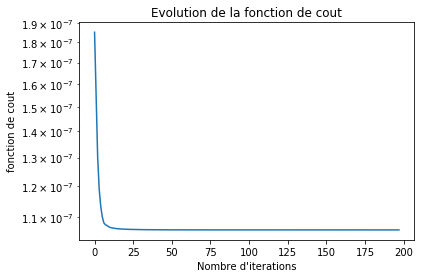

In [346]:
plt.plot(energy[1:])
plt.yscale("log")
plt.xlabel("Nombre d'iterations")
plt.ylabel("fonction de cout")
plt.title("Evolution de la fonction de cout")
plt.yscale("log")
#plt.savefig("Cout_tot.png")

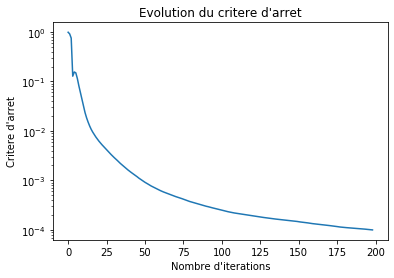

In [347]:
plt.plot(norms)
plt.yscale("log")
plt.xlabel("Nombre d'iterations")
plt.ylabel("Critere d'arret")
plt.title("Evolution du critere d'arret")
plt.yscale("log")
#plt.savefig("norm_tot.png")

Parameter values that work well: lower_level_parameters = {"zeta":1e15,"pn1":1e-6,"epsilon":1e-2,"gamma":1e-10}. With these parameters, a better convergence speed is obtained with myconst = {"sigma":1.15,"tau":0.43}

## Convergence tests
Test of different values for $\sigma$ and $\tau$ to see if we can accelerate the convergence 

In [304]:
#Values used by the algorithm
real = compute_constants(lower_level_parameters,{})

Ntest1D = 11
sigma_test = real["sigma"]*np.logspace(-2,2,Ntest1D)
tau_test = real["tau"]*np.logspace(-2,2,Ntest1D)

X,Y = np.meshgrid(sigma_test,tau_test)
const_to_test = np.stack([X.flatten('F'),Y.flatten('F')],axis=1)

In [305]:
final_ssims = np.zeros((Ntest1D,Ntest1D))
final_norms = np.zeros((Ntest1D,Ntest1D))

for i in range(Ntest1D**2):
    print("\n\n",i+1,"e test:\n")
    uk,norms = pdhg(y,p,lower_level_parameters,const={"sigma":const_to_test[i,0],"tau":const_to_test[i,1]},
                   maxit=50,compute_energy=False)
    final_ssims[i//Ntest1D,i%Ntest1D] = ssim(uk,u0_mat)
    final_norms[i//Ntest1D,i%Ntest1D] = norms[-1]



 1 e test:



/home/guillaume/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until
/home/guillaume/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


10  iterations:
Norm: 0.10375415048379558 

20  iterations:
Norm: 0.03754437751728409 

30  iterations:
Norm: 0.013330771931289002 

40  iterations:
Norm: 0.006926542094129989 

50  iterations:
Norm: 0.004649362160113958 

Finished in 20.16586709022522 seconds.


 2 e test:

10  iterations:
Norm: 0.10443767096876072 

20  iterations:
Norm: 0.03778137884678564 

30  iterations:
Norm: 0.013300007963866921 

40  iterations:
Norm: 0.006849494555343602 

50  iterations:
Norm: 0.0045992457767054604 

Finished in 19.43276357650757 seconds.


 3 e test:

10  iterations:
Norm: 0.10615913118157612 

20  iterations:
Norm: 0.03833644584463659 

30  iterations:
Norm: 0.013191273444623949 

40  iterations:
Norm: 0.006649213917518395 

50  iterations:
Norm: 0.004431170970153608 

Finished in 19.4494526386261 seconds.


 4 e test:

10  iterations:
Norm: 0.11050994790437774 

20  iterations:
Norm: 0.03939091311244656 

30  iterations:
Norm: 0.01262849975341715 

40  iterations:
Norm: 0.0059390956068186

50  iterations:
Norm: 0.0027893817177139075 

Finished in 19.05672264099121 seconds.


 31 e test:

10  iterations:
Norm: 0.043213131882565654 

20  iterations:
Norm: 0.006515821426553421 

30  iterations:
Norm: 0.0028860423635835397 

40  iterations:
Norm: 0.0014981365562716346 

50  iterations:
Norm: 0.0008867317469396192 

Finished in 19.23546600341797 seconds.


 32 e test:

10  iterations:
Norm: 2.292320351360993 

20  iterations:
Norm: 2.340274306263407 

30  iterations:
Norm: 2.349708891256997 

40  iterations:
Norm: 2.354934651411977 

50  iterations:
Norm: 2.3575725637481493 

Finished in 19.45844578742981 seconds.


 33 e test:

10  iterations:
Norm: 4.186556130865329 

20  iterations:
Norm: 3.397966972635049 

30  iterations:
Norm: 3.313837039768093 

40  iterations:
Norm: 3.2856019905869323 

50  iterations:
Norm: 3.2711231014470235 

Finished in 19.298734664916992 seconds.


 34 e test:

10  iterations:
Norm: 0.014904993584709984 

20  iterations:
Norm: 0.00497735759746869

50  iterations:
Norm: 0.04066974502145179 

Finished in 20.25677490234375 seconds.


 61 e test:

10  iterations:
Norm: 0.12818706250329803 

20  iterations:
Norm: 0.06794097454002222 

30  iterations:
Norm: 0.039173012461795685 

40  iterations:
Norm: 0.024743432158010746 

50  iterations:
Norm: 0.01717733381734033 

Finished in 19.308035373687744 seconds.


 62 e test:

10  iterations:
Norm: 0.3073061067568887 

20  iterations:
Norm: 0.38971907492178287 

30  iterations:
Norm: 0.7317868118690536 

40  iterations:
Norm: 0.9550080785016429 

50  iterations:
Norm: 1.0349145001116629 

Finished in 19.898579835891724 seconds.


 63 e test:

10  iterations:
Norm: 1.4434317994821448 

20  iterations:
Norm: 1.4455040445077698 

30  iterations:
Norm: 1.4479519656506328 

40  iterations:
Norm: 1.4498752898115659 

50  iterations:
Norm: 1.4517970856226932 

Finished in 20.464496612548828 seconds.


 64 e test:

10  iterations:
Norm: 2.1381002212746076 

20  iterations:
Norm: 2.1554026980937917 

10  iterations:
Norm: 0.040537389181356374 

20  iterations:
Norm: 0.04031665980654758 

30  iterations:
Norm: 0.04001233936566415 

40  iterations:
Norm: 0.03891457572527358 

50  iterations:
Norm: 0.038395662066777206 

Finished in 20.533769130706787 seconds.


 92 e test:

10  iterations:
Norm: 0.09838597117646017 

20  iterations:
Norm: 0.0938612788272937 

30  iterations:
Norm: 0.08836091773032988 

40  iterations:
Norm: 0.08183234186792891 

50  iterations:
Norm: 0.07464530665386544 

Finished in 19.8450026512146 seconds.


 93 e test:

10  iterations:
Norm: 0.7509325733359501 

20  iterations:
Norm: 0.9716096740505327 

30  iterations:
Norm: 1.0610038002885318 

40  iterations:
Norm: 1.1043683558302868 

50  iterations:
Norm: 1.1271676794328949 

Finished in 19.905831575393677 seconds.


 94 e test:

10  iterations:
Norm: 1.0568385211019666 

20  iterations:
Norm: 1.158095741978794 

30  iterations:
Norm: 1.1767934942808453 

40  iterations:
Norm: 1.1799203235261988 

50  iterat

30  iterations:
Norm: 5.626565847647777 

40  iterations:
Norm: 5.660480633665493 

50  iterations:
Norm: 5.684380566519918 

Finished in 20.73764657974243 seconds.


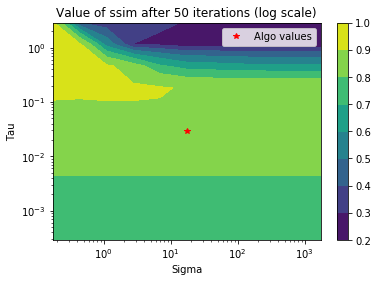

In [349]:
plt.contourf(X,Y,final_ssims.transpose())
plt.plot(real["sigma"],real["tau"],'r*', label="Algo values")
plt.title("Value of ssim after 50 iterations (log scale)")
plt.xlabel("Sigma")
plt.ylabel("Tau")
plt.xscale("log")
plt.yscale("log")
plt.colorbar()
plt.legend()
plt.savefig("ssims.png")
plt.show()

In [350]:
# Get the indices of minimum element in numpy array
result = np.where(final_norms == np.amin(final_norms))
print(tau_test[result[1]],sigma_test[result[0]])

[1.14923641] [0.43507149]
